In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data
from skimage import io

In [5]:
plt.ion()   # interactive mode

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [17]:
data_directory = 'C:\Programming\python\Tuberculosis_detection_using_deep_learning_and_CNN\Tuberculosis_dataset\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png'
# print(data_directory)

#Loading from all_files in data_directory
#Data loader we will define as batch size 8 and number of workers as 4
all_files = os.listdir(data_directory)
del(all_files[len(all_files) - 1])

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\honey\AppData\Local\Temp\ipykernel_20328\3810859733.py:1: SyntaxWarning: invalid escape sequence '\P'
  data_directory = 'C:\Programming\python\Tuberculosis_detection_using_deep_learning_and_CNN\Tuberculosis_dataset\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png'


In [51]:
all_files = np.array(all_files)
#singlechannel_files = np.array(singlechannel_files)
np.random.shuffle(all_files)

train_files = all_files[:round(0.05*all_files.shape[0])]
test_files = all_files[round(0.95*all_files.shape[0]):]


In [32]:
print(len(train_files))
print(len(test_files))

33
33


In [33]:
categories = {'0':0,'1':0}
for file in test_files:
    categories[file[-5]] += 1

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([ transforms.ToTensor()])

In [46]:
device = None
if torch.xpu.is_available():
    device = torch.device("xpu")
    print("Using Intel GPU")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using NVIDIA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
# print(device)

Using CPU


33
33
Training set size: 33
Validation set size: 33
Batch size: 8


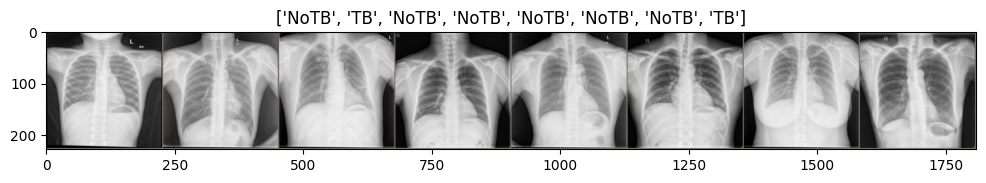

In [52]:
# import os
# import numpy as np
# import torch
# import torch.utils.data as data
# from torchvision import transforms
# import torchvision
# from skimage import io
# from skimage.transform import resize
# import matplotlib.pyplot as plt

# Set the data directory
# data_directory = '../ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png'

# Define image transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom loader function
def CNNloader(data_root, filename):
    filename_actual = os.path.join(data_root, filename)
    data_old = io.imread(filename_actual)
    data_old = resize(data_old, (224, 224))
    data_old = np.array(data_old, dtype=np.float32)
    
    if len(data_old.shape) <= 2:
        data_new = np.zeros((224, 224, 3))
        data_new[:,:,0] = data_new[:,:,1] = data_new[:,:,2] = np.array(data_old)
        data_old = np.array(data_new, dtype=np.float32)
    
    data_old = data_transforms(np.array(data_old))
    return data_old

# Custom Dataset class
class CNNDataLayer(data.Dataset):
    def __init__(self, data_root, filenames, loader):
        self.data_root = data_root
        self.filenames = filenames
        self.loader = loader

    def __getitem__(self, index):
        filename = self.filenames[index]
        target = int(filename[-5])  # Assuming the label is the second-to-last character
        target = torch.tensor([target], dtype=torch.float32)
        data = self.loader(self.data_root, filename)
        return data, target

    def __len__(self):
        return len(self.filenames)

# Get all file names and split into train and test
all_files = [f for f in os.listdir(data_directory) if f.endswith('.png')]
np.random.shuffle(all_files)
split = int(0.8 * len(all_files))
# train_files = all_files[:split]
# test_files = all_files[split:]
print(len(train_files))
print(len(test_files))

# Create datasets
data_sets_train = CNNDataLayer(data_root=data_directory, filenames=train_files, loader=CNNloader)
data_sets_test = CNNDataLayer(data_root=data_directory, filenames=test_files, loader=CNNloader)

# Create data loaders
data_loaders_train = data.DataLoader(
    data_sets_train,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)
data_loaders_test = data.DataLoader(
    data_sets_test,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

image_datasets = {'train': data_sets_train, 'val': data_sets_test}
dataloaders = {'train': data_loaders_train, 'val': data_loaders_test}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = ['NoTB', 'TB']
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Training set size: {dataset_sizes['train']}")
print(f"Validation set size: {dataset_sizes['val']}")
print(f"Batch size: {dataloaders['train'].batch_size}")

# Function to show image
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Show images
plt.figure(figsize=(12, 6))
imshow(out, title=[class_names[int(x.item())] for x in classes])
plt.show()

In [53]:
def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

    return(output)

outputSize(224,2,2,0)

112

In [54]:
class SimpleCNN(torch.nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = torch.nn.Sequential(torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1), 
                                            torch.nn.ReLU(inplace = True), 
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                                            torch.nn.Conv2d(18, 20, kernel_size=3, stride=1, padding=1), 
                                            torch.nn.ReLU(inplace = True), 
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                                            torch.nn.Conv2d(20, 32, kernel_size=3, stride=1, padding=1), 
                                            torch.nn.ReLU(inplace = True), 
                                            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),)
        
        self.classifier = torch.nn.Sequential(torch.nn.Linear(32 * 28 * 28, 64), 
                                              torch.nn.ReLU(inplace = True), 
                                              torch.nn.Linear(64, 1), 
                                              torch.nn.Sigmoid())

    def forward(self, x):
        #Computes the activation of the first convolution
        #Size changes from (3, 224, 224) to (18, 224, 24)
        x = self.features(x)
        
        #Size changes from (3, 224, 224) to (18, 112, 112)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 32 * 28 * 28)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = self.classifier(x)
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        return(x)
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [55]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch is ' + str(epoch))
        train_loss = 0
        test_loss = 0
        total_misclassified_train = 0
        total_count_train = 0
        total_misclassified_test = 0
        total_count_test = 0
        total_false_negatives_train = 0
        total_false_positives_train = 0
        total_false_negatives_test = 0
        total_false_positives_test = 0
        for data_now, target_now in dataloaders['train']:
            #scheduler.step()
            model.train()  # Set model to training mode
            data_now = data_now.to(device)
            target_now = target_now.type(torch.FloatTensor)
            target_now = target_now.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                target_output_model = model(data_now)
                target_loss = criterion(target_output_model, target_now)
                target_loss.backward()
                optimizer.step()
            #Estimating accuracy
            misclassified_temp = target_output_model[target_now == 1]
            false_negatives_train = misclassified_temp[misclassified_temp < 0.5].size()[0]
            misclassified_temp = target_output_model[target_now == 0]
            false_positives_train = misclassified_temp[misclassified_temp >= 0.5].size()[0]
            total_misclassified_train += false_negatives_train + false_positives_train
            total_false_positives_train += false_positives_train
            total_false_negatives_train += false_negatives_train
            total_count_train += data_now.shape[0]
            
        for data_now, target_now in dataloaders['val']:
            model.eval()   # Set model to evaluate mode
      #      print('Data shape is')
       #     print(data_now.shape)
            data_now = data_now.to(device)
            target_now = target_now.to(device)
            with torch.set_grad_enabled(False):
                target_output_model = model(data_now)
                
            misclassified_temp = target_output_model[target_now == 1]
            false_negatives_test = misclassified_temp[misclassified_temp < 0.5].size()[0]
            misclassified_temp = target_output_model[target_now == 0]
            false_positives_test = misclassified_temp[misclassified_temp >= 0.5].size()[0]
            total_misclassified_test += false_negatives_test + false_positives_test
            total_false_positives_test += false_positives_test
            total_false_negatives_test += false_negatives_test
            total_count_test += data_now.shape[0]

        epoch_loss = total_misclassified_train / total_count_train
        epoch_acc = (total_count_train - total_misclassified_train) / total_count_train
        print("Classified " + str(total_count_train - total_misclassified_train) + " out of " + str(total_count_train) + " correctly.")
        print('{} Loss: {:.4f} Acc: {:.4f} False Positives: {} False Negatives: {}'.format(
            'train', epoch_loss, epoch_acc, total_false_positives_train, total_false_negatives_train))

        epoch_loss = total_misclassified_test / total_count_test
        epoch_acc = (total_count_test - total_misclassified_test) / total_count_test
        print("Classified " + str(total_count_test - total_misclassified_test) + " out of " + str(total_count_test) + " correctly.")
        print('{} Loss: {:.4f} Acc: {:.4f} False Positives: {} False Negatives: {}'.format(
            'val', epoch_loss, epoch_acc, total_false_positives_test, total_false_negatives_test))

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

        #Saving the weights now
        snapshot_path = './snapshotsOwnCNN'
        if not os.path.isdir(snapshot_path):
            os.makedirs(snapshot_path)
        snapshot_name = 'epoch-{}-trainerror-{}-testerror-{}.pth'.format(epoch, 
                               float(total_misclassified_train / total_count_train),
                               float(total_misclassified_test / total_count_test))
        
        torch.save(model.state_dict(), os.path.join(snapshot_path, snapshot_name))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [57]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs > 0.5
            
            """
            #Estimating accuracy
            misclassified_temp = target_output_model[target_now == 1]
            misclassified_count_positive = misclassified_temp[misclassified_temp < 0.5].size()[0]
            misclassified_temp = target_output_model[target_now == 0]
            misclassified_count_negative = misclassified_temp[misclassified_temp >= 0.5].size()[0]
            total_misclassified_train += misclassified_count_positive + misclassified_count_negative
            total_count_train += data_now.shape[0]
            """
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]] + ":" + class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = SimpleCNN()
#num_ftrs = model_ft.fc1.in_features
#model_ft.fc1 = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.006, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)

visualize_model(model_ft, 14)

Epoch is 0
